In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
from entot.data.data import create_gaussians, create_gaussian_split
from entot.plotting.plots import plot_1D
from entot.models.utils import MixtureNormalSampler
import ott
import matplotlib.pyplot as plt
import numpy as np
import optax
import jax
import jax.numpy as jnp
import scanpy as sc

from entot.models.gen_model import OTFlowMatching, MLP_FM, MLP_FM2, OriginalFlowMatching, MLP_no_noise

2023-07-11 13:02:34.146040: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
adata = sc.read("../../../../data/adata_pancreas_2019_processed_new.h5ad")

In [5]:
sc.pp.pca(adata, n_comps=10)

In [6]:
source = adata[adata.obs["day"]=="14.5"].obsm["X_pca"].copy()
target = adata[adata.obs["day"]=="15.5"].obsm["X_pca"].copy()


In [19]:
neural_net = MLP_no_noise(10, [64, 64, 64, 64], n_frequencies=10)
otfm = OriginalFlowMatching(neural_net, 10, 5000)

In [20]:
otfm(source, target, 800, 800)

100%|██████████| 5000/5000 [02:35<00:00, 32.18it/s]


In [9]:
#plt.plot(np.arange(len(otfm.metrics["loss"])), otfm.metrics["loss"])

In [11]:
#plt.plot(np.arange(len(otfm.metrics["loss"][800:])), otfm.metrics["loss"][800:])

In [21]:
pushed,_ = otfm.transport(source)

In [22]:
bdata = adata.copy()
bdata.obsm["X_pca_result"] = np.concatenate((pushed[0,...], target), axis=0)

In [23]:
sc.pp.neighbors(bdata, use_rep="X_pca_result")

In [24]:
sc.tl.umap(bdata)

/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


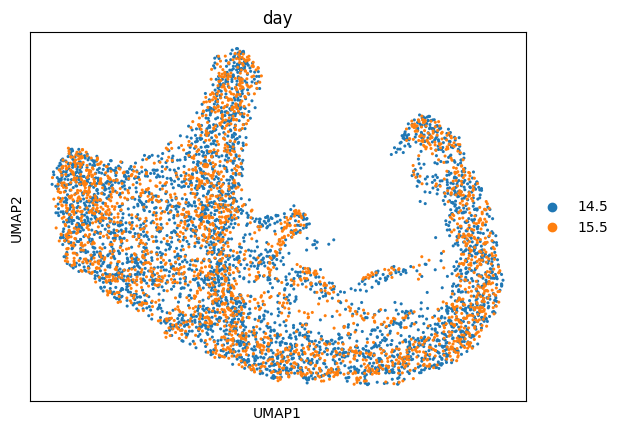

In [25]:
sc.pl.umap(bdata, color="day")

/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


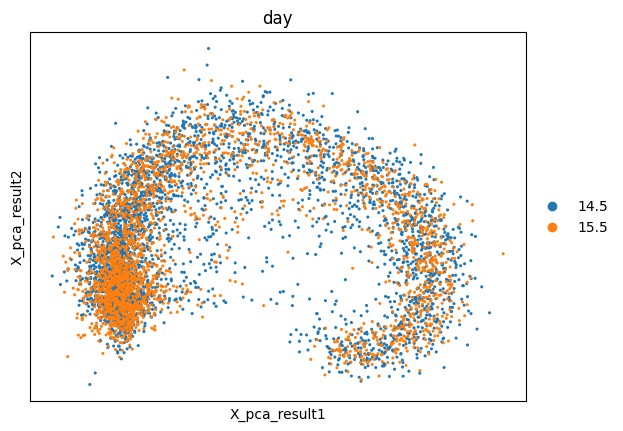

In [26]:
sc.pl.embedding(bdata, basis="X_pca_result", color="day")

/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


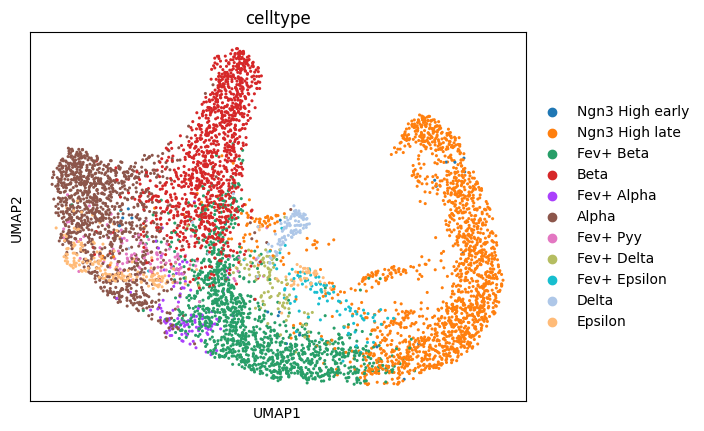

In [27]:
sc.pl.umap(bdata, color="celltype")

In [52]:
adata.obsm["X_pca_original"] = np.concatenate((source, target), axis=0)


In [53]:
sc.pp.neighbors(adata, use_rep="X_pca_original")

In [54]:
sc.tl.umap(adata)

/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


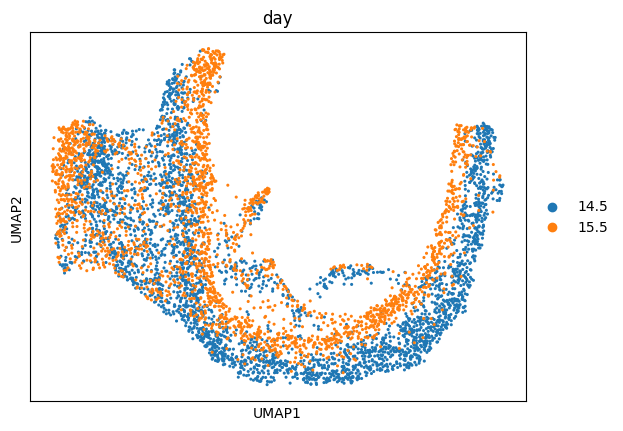

In [55]:
sc.pl.umap(adata, color="day")

/home/dominikk/mambaforge/envs/ott_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


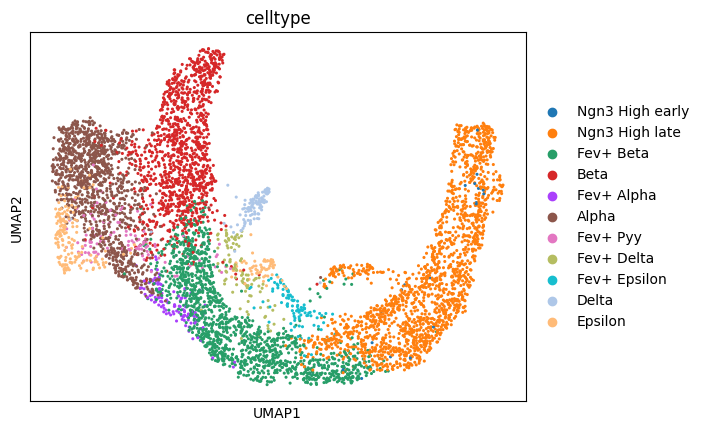

In [56]:
sc.pl.umap(adata, color="celltype")

In [57]:
res = [None] * 15

for i in range(15):
    res[i]= otfm.transport(source, seed=i)[0][0,...]


In [58]:
samples = jnp.array(res)

In [59]:
samples.shape

(15, 3575, 10)

In [60]:
vars = jnp.var(samples, axis=0)

In [61]:
vars_summed = jnp.sum(vars, axis=1)

In [62]:
fill = np.empty(len(target))[:, None]
fill[:] = np.nan
bdata.obs["var"] = np.asarray(np.concatenate((vars_summed[:, None], fill)))

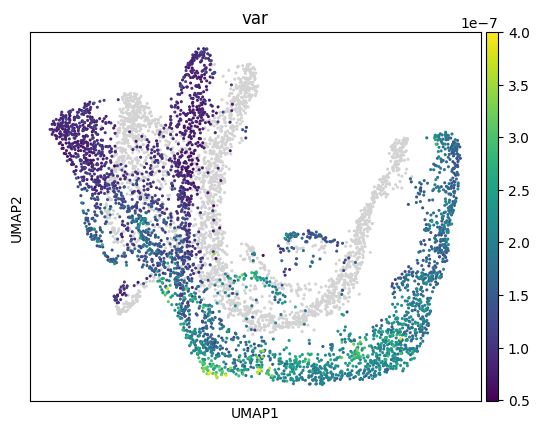

In [63]:
sc.pl.umap(bdata, color="var")

In [64]:
bdata.obs[["celltype", "var"]].groupby("celltype").mean()

,var
celltype,
Ngn3 High early,1.884327e-07
Ngn3 High late,1.868475e-07
Fev+ Beta,1.864223e-07
Beta,8.797143e-08
Fev+ Alpha,1.878583e-07
Alpha,1.040547e-07
Fev+ Pyy,1.318387e-07
Fev+ Delta,1.612975e-07
Fev+ Epsilon,2.199629e-07


In [35]:
cdata = bdata[~bdata.obs["celltype"].isin(["Acinar", "Ductal", "Tip", "Trunk", "Multipotent", "Ngn3 low EP"])].copy()

/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


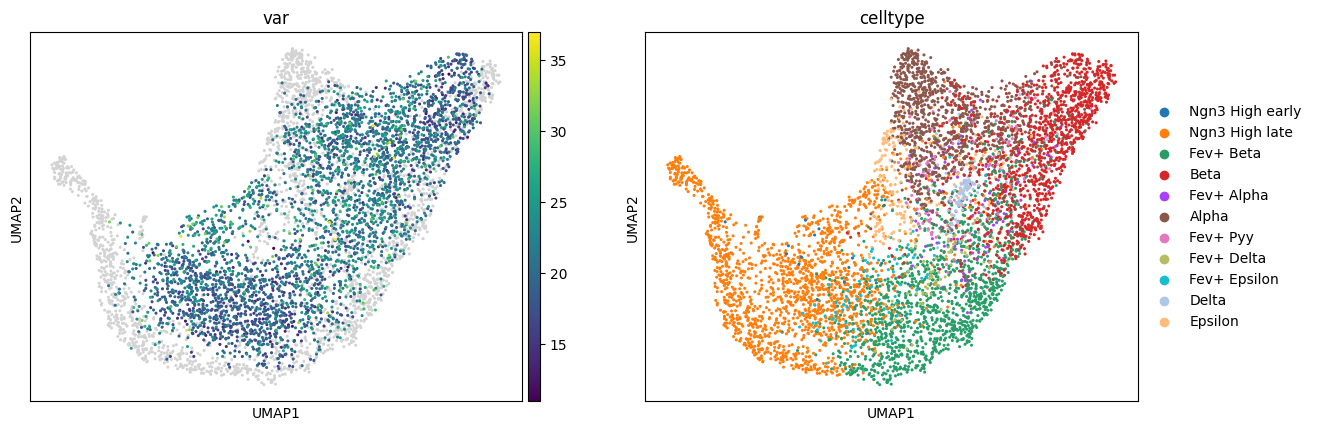

In [36]:
sc.pl.umap(cdata, color=["var", "celltype"])